In [ ]:
#import requests
#import os

#url = 'https://unisydneyedu-my.sharepoint.com/:u:/g/personal/vcor0924_uni_sydney_edu_au/Ec-tGVv4UqREnPKNuArkFTYB6fRHL8GwC-5NQ36p9V_T7w?e=k9RnyS&download=1' 
#output_file = "lung_colon_image_set.zip"

#with requests.get(url, stream=True) as response:
#    response.raise_for_status()  # Check for errors
#    with open(output_file, "wb") as file:
#        for chunk in response.iter_content(chunk_size=1048576):  # 1 MB chunks
#            file.write(chunk)

In [ ]:
#import zipfile
#with zipfile.ZipFile(output_file, 'r') as zip_ref:
#    zip_ref.extractall('dataset')  # Extract into 'dataset' folder

In [2]:
import torch
import torch.nn as nn
import torchvision.models as models

def Net():  
    # Load the pre-trained VGG11 model
    vgg11 = models.vgg11(pretrained=True)

    # Freeze the feature extractor layers (optional)
    for param in vgg11.features.parameters():
        param.requires_grad = False

    # Modify the classifier (fc layers) for binary classification
    # Here we replace the original final classifier layer with one for binary classification
    vgg11.classifier[6] = nn.Sequential(
        nn.Linear(4096, 1),  # Adjusting for the new input features (4096 is the number of features)
        nn.Sigmoid()  # Sigmoid activation for binary classification (output between 0 and 1)
    )

    return vgg11

In [3]:
import torch

def train(net, trainloader, optimizer, device):
    criterion = torch.nn.BCELoss().to(device)
    net.to(device)
    net.train()

    running_loss = 0.0
    total_samples = 0

    for batch in trainloader:
        images = batch["image"].to(device)
        labels = batch["label"].float().unsqueeze(1).to(device)  # shape: (B, 1)

        optimizer.zero_grad()
        outputs = net(images)  # shape: (B, 1)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * labels.size(0)
        total_samples += labels.size(0)

    avg_loss = running_loss / total_samples
    return avg_loss


def test(net, testloader, device):
    """Evaluate the model on the test set."""
    criterion = torch.nn.BCELoss().to(device)
    net.to(device)
    net.eval()

    total_samples = 0
    total_loss = 0.0
    total_correct = 0

    with torch.no_grad():
        for batch in testloader:
            images = batch["image"].to(device)
            labels = batch["label"].float().unsqueeze(1).to(device)  # shape: (B, 1)

            outputs = net(images)  # shape: (B, 1)
            loss = criterion(outputs, labels)
            preds = (outputs > 0.5).float()

            total_correct += (preds == labels).sum().item()
            total_loss += loss.item() * labels.size(0)
            total_samples += labels.size(0)

    avg_loss = total_loss / total_samples
    accuracy = total_correct / total_samples

    return avg_loss, accuracy


In [4]:
from datasets import load_dataset

dataset_path = "dataset/colon_image_sets"
ds = load_dataset("imagefolder", data_dir=dataset_path)

dataset = ds['train'].shuffle()

Resolving data files:   0%|          | 0/10000 [00:00<?, ?it/s]

In [5]:
from flwr_datasets.partitioner import DirichletPartitioner
from flwr_datasets.partitioner import IidPartitioner

NUM_PARTITIONS = 3
alpha = 0.95

partitioner = DirichletPartitioner(num_partitions=NUM_PARTITIONS, partition_by="label", alpha=alpha, min_partition_size=10)
#partitioner = IidPartitioner(num_partitions=NUM_PARTITIONS)

partitioner.dataset = dataset

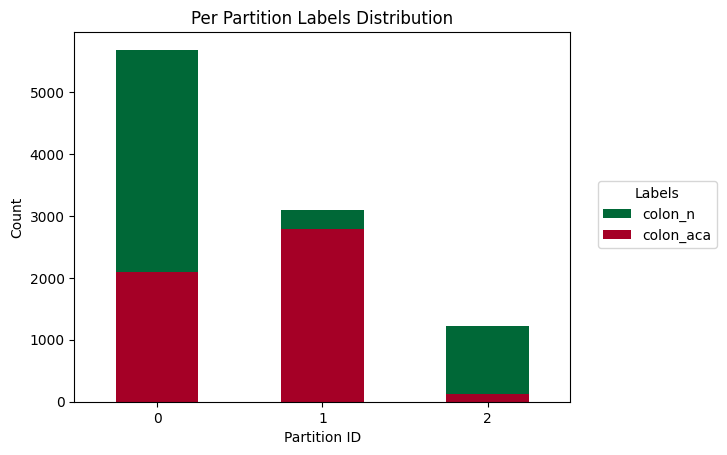

In [9]:
from flwr_datasets.visualization import plot_label_distributions

fig, ax, df = plot_label_distributions(
    partitioner,
    label_name="label",
    plot_type="bar",
    size_unit="absolute",
    partition_id_axis="x",
    legend=True,
    verbose_labels=True,
    max_num_partitions=30,  # Note we are only showing the first 30 so the plot remains readable
    title="Per Partition Labels Distribution",
)

In [10]:
from collections import OrderedDict
from typing import Dict, Tuple

import torch
from flwr.common import NDArrays, Scalar
from flwr.client import NumPyClient


class FlowerClient(NumPyClient):
    def __init__(self, trainloader, valloader, id) -> None:
        super().__init__()

        self.trainloader = trainloader
        self.valloader = valloader
        self.id = id
        self.model = Net()
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    def fit(self, parameters, config):
        """This method trains the model using the parameters sent by the
        server on the dataset of this client. At then end, the parameters
        of the locally trained model are communicated back to the server"""

        # copy parameters sent by the server into client's local model
        set_params(self.model, parameters)

        # Define the optimizer
        trainable_params = filter(lambda p: p.requires_grad, self.model.parameters())
        optim = torch.optim.Adam(trainable_params, lr=0.001)

        # do local training (call same function as centralised setting)
        train(self.model, self.trainloader, optim, self.device)

        # return the model parameters to the server as well as extra info (number of training examples in this case)
        return get_params(self.model), len(self.trainloader), {}

    def evaluate(self, parameters: NDArrays, config: Dict[str, Scalar]):
        """Evaluate the model sent by the server on this client's
        local validation set. Then return performance metrics."""

        set_params(self.model, parameters)
        # do local evaluation (call same function as centralised setting)
        loss, accuracy = test(self.model, self.valloader, self.device)
        # send statistics back to the server
        return float(loss), len(self.valloader), {"accuracy": accuracy, "loss": loss, 'id': self.id}



# Two auxhiliary functions to set and extract parameters of a model
def set_params(model, parameters):
    """Replace model parameters with those passed as `parameters`."""

    params_dict = zip(model.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.from_numpy(v) for k, v in params_dict})
    # now replace the parameters
    model.load_state_dict(state_dict, strict=True)


def get_params(model):
    """Extract model parameters as a list of NumPy arrays."""
    return [val.cpu().numpy() for _, val in model.state_dict().items()]

In [11]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor, Normalize, Compose
from datasets import load_dataset


def get_dataloaders(dataset, batch_size: int):
    pytorch_transforms = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    # Prepare transformation functions
    def apply_transforms(batch):
        batch["image"] = [pytorch_transforms(img) for img in batch["image"]]
        return batch

    train = dataset["train"].with_transform(apply_transforms)
    test = dataset["test"].with_transform(apply_transforms)

    # Construct PyTorch dataloaders
    trainloader = DataLoader(train, batch_size=batch_size, shuffle=True)
    testloader = DataLoader(test, batch_size=batch_size)
    return trainloader, testloader

In [12]:
from flwr.common import Context
from flwr.client import ClientApp


def client_fn(context: Context):
    """Returns a FlowerClient containing its data partition."""

    partition_id = int(context.node_config["partition-id"])
    partition = partitioner.load_partition(partition_id)
    partition_train_val = partition.train_test_split(test_size=0.2, seed=42)
    trainloader, testloader = get_dataloaders(partition_train_val, batch_size=32)

    return FlowerClient(trainloader=trainloader, valloader=testloader, id=partition_id).to_client()

# Concstruct the ClientApp passing the client generation function
client_app = ClientApp(client_fn=client_fn)

In [13]:
from typing import List
from flwr.common import Metrics

client_metrics = []

# Define metric aggregation function
def weighted_average(metrics: List[Tuple[int, Metrics]]) -> Metrics:
    # Multiply accuracy of each client by number of examples used
    client_metrics.append(metrics)
    print(metrics)
    accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]

    # Aggregate and return custom metric (weighted average)
    return {"accuracy": sum(accuracies) / sum(examples)}

In [14]:
from flwr.common import ndarrays_to_parameters
from flwr.server import ServerApp, ServerConfig, ServerAppComponents
from flwr.server.strategy import FedAvg

num_rounds = 3

def server_fn(context: Context):

    # instantiate the model
    model = Net()
    ndarrays = get_params(model)
    # Convert model parameters to flwr.common.Parameters
    global_model_init = ndarrays_to_parameters(ndarrays)

    # Define the strategy
    strategy = FedAvg(
        fraction_fit=1.0,  # % clients sampled each round to do fit()
        fraction_evaluate=1.0,  # % clients sample each round to do evaluate()
        evaluate_metrics_aggregation_fn=weighted_average,  # callback defined earlier
        initial_parameters=global_model_init,  # initialised global model
    )

    # Construct ServerConfig
    config = ServerConfig(num_rounds=num_rounds)

    # Wrap everything into a `ServerAppComponents` object
    return ServerAppComponents(strategy=strategy, config=config)


# Create your ServerApp
server_app = ServerApp(server_fn=server_fn)

In [ ]:
sAimport ray

dsAimport ray

#ray.init(object_store_memory=200 * 1024 * 1024)  # 200 MB (adjust as needed)import ray

#ray.init(object_store_memory=200 * 1024 * 1024)  # 200 MB (adjust as needed)import ray

#ray.init(object_store_memory=200 * 1024 * 1024)  # 200 MB (adjust as needed)

In [ ]:
from flwr.simulation import run_simulation

history = run_simulation(
    server_app=server_app, client_app=client_app, num_supernodes=NUM_PARTITIONS,
)

/home/codespace/.local/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/codespace/.local/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG11_Weights.IMAGENET1K_V1`. You can also use `weights=VGG11_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


INFO :      Starting Flower ServerApp, config: num_rounds=3, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      Evaluation returned no results (`None`)
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)
ERROR :     An exception was raised when processing a message by RayBackend
ERROR :     The actor died unexpectedly before finishing this task.
	class_name: ClientAppActor
	actor_id: 02416516598aa16869b89d3301000000
	pid: 19787
	namespace: e78ac272-148d-4a1d-8e74-d9d350269a7f
	ip: 10.0.0.144
The actor is dead because its worker process has died. Worker exit type: SYSTEM_ERROR Worker exit detail: Worker exits unexpectedly. Worker exits with an exit code 1. The process receives a SIGTERM.
ERROR :     Traceback (most recent call last):
  File "/home/codespace/.local/lib/python3.12/site-packages/flwr/server/s

In [14]:
client_accs = [[] for _ in range(len(client_metrics[0]))]  # List of lists to store accuracies for each client
client_losses = [[] for _ in range(len(client_metrics[0]))]  # List of lists to store losses for each client

# Loop through each round of experiment (outer list)
for round_data in client_metrics:
    # Loop through each client (inner list)
    for client_idx, (_, metrics) in enumerate(round_data):
        # Append the accuracy and loss for the current client in this round
        client_accs[metrics['id']].append(metrics['accuracy'])
        client_losses[metrics['id']].append(metrics['loss'])

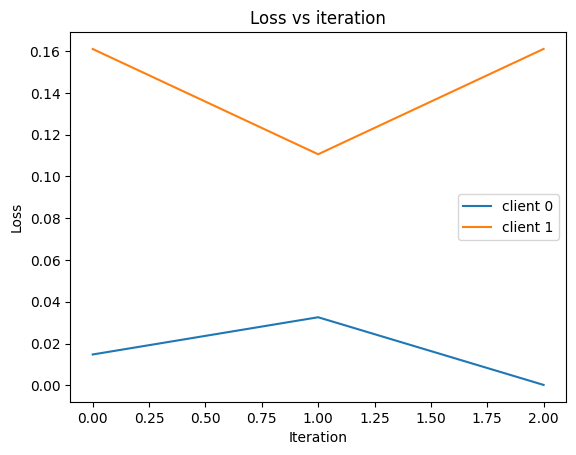

In [15]:
import matplotlib.pyplot as plt

# Create the line plot
for i, client in enumerate(client_losses):
    plt.plot(client, label='client ' + str(i))
plt.title("Loss vs iteration")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()
plt.show()

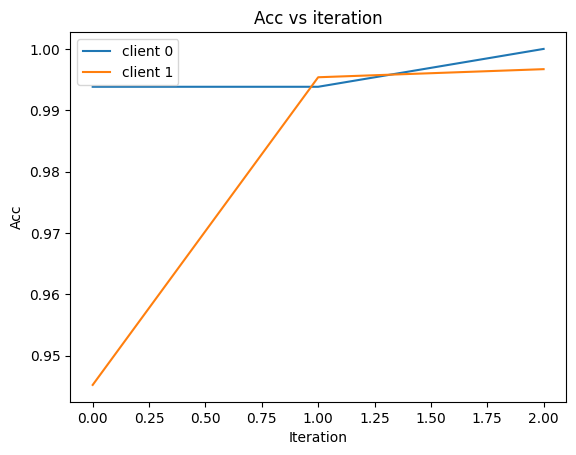

In [16]:
import matplotlib.pyplot as plt

# Create the line plot
for i, client in enumerate(client_accs):
    plt.plot(client, label='client ' + str(i))
plt.title("Acc vs iteration")
plt.xlabel("Iteration")
plt.ylabel("Acc")
plt.legend()
plt.show()